In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import os
import re
import librosa
import matplotlib.pyplot as plt

import ESC
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2

In [2]:
def Load_ESC10(path):
    '''
        Input:
            path: folder of the dataset
        
        Output:
            raw_data:  list that contains the raw data
            cvs:       list that contains the cross-fold number
            labels:    list that contains the category information
    '''
    
    # Container for the dataset
    raw_data = []
    cvs = []
    labels = []

    # Extract ESC10 files name
    df = pd.read_csv(glob('meta/esc50.csv')[0])

    # filter columns
    df = df[['filename', 'esc10']]

    # Load every file inside the folder
    for file_name in tqdm(os.listdir(path)):

        # Check if file_name is an esc10
        row = df[df['filename']==file_name]
        check = row.esc10.iloc[0]

        if check==True:    
            try:
                # Get audio data and sampling rate
                audio, sampling_rate = librosa.load(os.path.join(path, file_name), res_type='kaiser_fast')

                # Split the file name
                name_splitted = re.split('[-.]', file_name)

                # Append a row of 3 elements
                raw_data.append(audio)
                cvs.append(name_splitted[0])
                labels.append(name_splitted[3])
                                
            except Exception as e:
                pass
    raw_audio = np.asarray(raw_data)
    cvs = np.asarray(cvs, dtype=int)
    labels = np.asarray(labels, dtype=int)

    return raw_audio, cvs, labels


def label_map(label):
    
    unique = np.unique(label)
    new_labels = np.arange(0, len(unique))
    
    for i in range(len(unique)):
        
        comp = unique[i]
        
        for k in range(len(label)):
            if label[k] == comp:
                label[k] = new_labels[i]
    
    return label

In [3]:
PATH = 'audio'
raw_files, cvs, labels = Load_ESC10(PATH)

labels = label_map(labels)


labels = to_categorical(labels, num_classes=10)
# Split the different folds
f1, f2, f3, f4, f5 = ESC.Split_Folds(raw_files, cvs, labels, verbose=True)

100%|██████████| 400/400 [00:00<00:00, 401272.81it/s]

Folds size: 80 - 80 - 80 - 80 - 80
Folds sample shape:  2
Folds sample data shape:  (110250,)
Folds sample label type:  (10,)


In [4]:
print(labels.shape)

(400, 10)


In [5]:
f1d, f1l = ESC.Split_Data_Label(f1)
f2d, f2l = ESC.Split_Data_Label(f2)
f3d, f3l = ESC.Split_Data_Label(f3)
f4d, f4l = ESC.Split_Data_Label(f4)


In [6]:
# Compute log-melspec and deltas
f1p, lf1p = ESC.Preprocessing(f1d, f1l)
f2p, lf2p = ESC.Preprocessing(f2d, f2l)
f3p, lf3p = ESC.Preprocessing(f3d, f3l)
f4p, lf4p = ESC.Preprocessing(f4d, f4l)

100%|██████████| 80/80 [00:00<00:00, 138.18it/s]


In [7]:
f1p = np.interp(f1p, (f1p.min(), f1p.max()), (0, +1))
f2p = np.interp(f2p, (f2p.min(), f2p.max()), (0, +1))
f3p = np.interp(f3p, (f3p.min(), f3p.max()), (0, +1))
f4p = np.interp(f4p, (f4p.min(), f4p.max()), (0, +1))

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

def PiczakNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    
    # First convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(57, 6), strides=1, padding='same', name='conv0')(X_input)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(4, 3), strides=(1, 3), padding='same')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second convolution block
    model = tf.keras.layers.Conv2D(80, kernel_size=(1, 3), strides=1, padding='same', name='conv1')(model)
    model = tf.keras.layers.Activation('relu')(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 3), padding='same')(model)
    
    # Flatten
    model = tf.keras.layers.Flatten()(model)
    
    # First fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc0')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Second fully-connected block
    model = tf.keras.layers.Dense(5000, activation='relu', name='fc1')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    
    # Output layer
    model = tf.keras.layers.Dense(10, activation=None, name='out')(model)
    
    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='PiczakNet')
    
    return model


def RawNet(input_shape):
    
    X_input = tf.keras.Input(input_shape)
    #print(input_shape)
    #model = tf.keras.layers.Reshape((input_shape[0], 1))(X_input)
    
    
    model = tf.keras.layers.Conv2D(24, kernel_size=(6, 6), strides=(1, 1), padding='same', name='conv3')(X_input)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(24, kernel_size=(6, 6), strides=(1, 1), padding='same', name='conv4')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv5')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(48, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv6')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', name='conv7')(model)
    model = tf.keras.layers.BatchNormalization(axis=3)(model)
    model = tf.keras.layers.Activation('relu')(model)
    
    model = tf.keras.layers.Flatten()(model)
    
    model = tf.keras.layers.Dense(200, activation='relu', name='ffc')(model)
    model = tf.keras.layers.Dropout(0.5)(model)
    model = tf.keras.layers.Dense(10, activation='softmax', name='out')(model)

    # Create model
    model = tf.keras.Model(inputs = X_input, outputs = model, name='RawNet')
    
    return model

PiczakNet = RawNet([60, 41, 2])
print(PiczakNet.summary())
plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

opt = tf.keras.optimizers.Adam(lr=0.0002)
loss_f = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
PiczakNet.compile(optimizer=opt, loss=loss_f, metrics=["accuracy"])

Model: "RawNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 41, 24)        1752      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 41, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 60, 41, 24)        0         
_________________________________________________________________
conv4 (Conv2D)               (None, 60, 41, 24)        20760     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 41, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 24)        0    

In [9]:
def CreateTrainingSet(f1, f2, f3, lf1, lf2, lf3, batch_size=32):
    
    # Create training set
    merged_training_data = np.concatenate((f1, f2, f3))
    merged_training_label = np.concatenate((lf1, lf2, lf3))
    
    # Shuffle the folds
    rnd_indices = np.arange(0, len(merged_training_data))
    rnd_indices = np.random.shuffle(rnd_indices)
    
    merged_training_data = merged_training_data[rnd_indices].reshape((len(f1) + len(f2) + len(f3), 60, 41, 2))
    merged_training_label = merged_training_label[rnd_indices].reshape((len(f1) + len(f2) + len(f3), 10))
    
    
    merged_training_data = merged_training_data.astype(np.float32)
    merged_training_label = merged_training_label.astype(np.float32)

    # Create dataset
    training_dataset = tf.data.Dataset.from_tensor_slices((merged_training_data, merged_training_label))
    
    # Cache the dataset
    training_dataset = training_dataset.cache("training_cache")
    
    # Shuffle all elements at every iteration
    training_dataset = training_dataset.shuffle(len(training_dataset))
    
    # Define batch_size and prefetch size
    training_dataset = training_dataset.batch(batch_size=batch_size).prefetch(buffer_size=1)
    
    return training_dataset

training_dataset = CreateTrainingSet(f1p, f2p, f3p, lf1p, lf2p, lf3p, batch_size=32)
validation_dataset = ESC.CreateValidationSet(f4p, lf4p, batch_size=32)

In [10]:
import time

max_epochs = 30

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):

    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))
    

Epoch  1: 	 t-loss: 1.611959 	 t-acc: 0.414522 	 v-loss: 2.293287 	 v-acc: 0.097826 	 time: 3.898
Epoch  2: 	 t-loss: 1.016267 	 t-acc: 0.631893 	 v-loss: 2.311517 	 v-acc: 0.097826 	 time: 1.271
Epoch  3: 	 t-loss: 0.797301 	 t-acc: 0.716452 	 v-loss: 2.290411 	 v-acc: 0.097826 	 time: 1.267
Epoch  4: 	 t-loss: 0.630060 	 t-acc: 0.766544 	 v-loss: 2.158572 	 v-acc: 0.206522 	 time: 1.268
Epoch  5: 	 t-loss: 0.543625 	 t-acc: 0.804688 	 v-loss: 1.929885 	 v-acc: 0.247283 	 time: 1.257
Epoch  6: 	 t-loss: 0.488431 	 t-acc: 0.824908 	 v-loss: 1.494936 	 v-acc: 0.452446 	 time: 1.277
Epoch  7: 	 t-loss: 0.434868 	 t-acc: 0.850643 	 v-loss: 1.379333 	 v-acc: 0.486413 	 time: 1.275
Epoch  8: 	 t-loss: 0.368139 	 t-acc: 0.862132 	 v-loss: 1.126312 	 v-acc: 0.573370 	 time: 1.263
Epoch  9: 	 t-loss: 0.353515 	 t-acc: 0.865809 	 v-loss: 1.159976 	 v-acc: 0.608696 	 time: 1.261
Epoch 10: 	 t-loss: 0.320264 	 t-acc: 0.876838 	 v-loss: 1.147295 	 v-acc: 0.626359 	 time: 1.268
Epoch 11: 	 t-loss: 

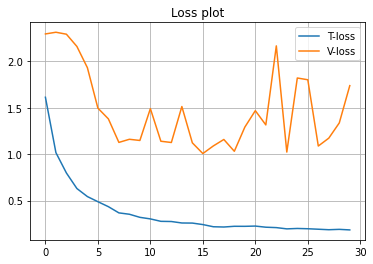

In [11]:
plt.figure()
plt.plot(epoch_loss, label='T-loss')
plt.plot(epoch_vl, label='V-loss')
plt.title('Loss plot')
plt.grid()
plt.legend()
plt.show()

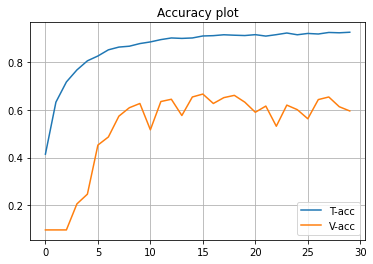

In [12]:
plt.figure()
plt.plot(epoch_acc, label='T-acc')
plt.plot(epoch_va, label='V-acc')
plt.title('Accuracy plot')
plt.grid()
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = PiczakNet.predict(f4p)

print(np.argmax(y_pred[0]))
#confusion_matrix(lf4p, y_pred)

9


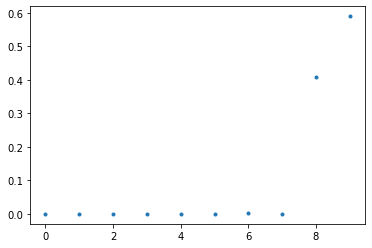

In [16]:
plt.figure()
plt.plot(y_pred[0], '.')
plt.show()